# 출국자수 예측

```
여행사에서 분석 업무를 담당하는 동현이는 해외 여러 나라의 여행상품을 기획하기 위해, 월별 해외여행 수요를 예측하고자 한다. 

수요가 많은 시즌에는 더 많은 상품을 구성하고 비수기에는 적은 인원대상의 상품이나 상품의 개수를 줄이려고 한다. 
월별 출국자수 정보를 활용하여 분석을 시작해보자.

63_py_Korean_outbound_travelers.csv(구분자: comma(“,”), 42 Rows, 13 Columns)
```

In [1]:
import pandas as pd
import scipy as sp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/63_py_Korean_outbound_travelers.csv')
df.head()

year   m_01   m_02   m_03   m_04   m_05   m_06   m_07   m_08   m_09   m_10  \
0  1975   9544   8549  10332  10504  11380   9746   9786  11282  10343  12243   
1  1976  11722  11355  12920  12519  13809  13841  13866  15299  13333  15067   
2  1977  14265  12820  17308  17172  17393  16165  17953  20484  18587  20752   
3  1978  17592  17156  19952  20115  22719  23054  23283  21479  24590  25537   
4  1979  21107  22583  23871  23244  25430  26288  24629  25056  25750  25339   

    m_11   m_12  
0  13137  12532  
1  15855  15141  
2  18863  17936  
3  23366  20735  
4  26887  25362

In [3]:
df.tail()

year     m_01     m_02     m_03     m_04     m_05     m_06     m_07  \
37  2012  1200782  1150334  1018952  1018645  1096950  1109273  1305418   
38  2013  1425900  1184807  1113946  1097420  1185405  1221491  1417422   
39  2014  1468903  1312683  1150959  1179885  1223003  1270439  1454795   
40  2015  1834538  1445609  1416683  1495460  1579265  1373551  1675332   
41  2016  2112337  1876928  1569162  1636597  1656728  1778317  2086068   

       m_08     m_09     m_10     m_11     m_12  
37  1334651  1059709  1154742  1117550  1169970  
38  1407186  1195238  1239143  1154064  1204463  
39  1547193  1321293  1432100  1288754  1430677  
40  1835249  1511657  1735308  1626063  1781715  
41  2064241  1904524  1865552  1825701  2007035

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   year    42 non-null     int64
 1   m_01    42 non-null     int64
 2   m_02    42 non-null     int64
 3   m_03    42 non-null     int64
 4   m_04    42 non-null     int64
 5   m_05    42 non-null     int64
 6   m_06    42 non-null     int64
 7   m_07    42 non-null     int64
 8   m_08    42 non-null     int64
 9   m_09    42 non-null     int64
 10  m_10    42 non-null     int64
 11  m_11    42 non-null     int64
 12  m_12    42 non-null     int64
dtypes: int64(13)
memory usage: 4.4 KB


## Q 1

```
데이터를 아래와 같이, 기준년월과 출국자수 형태로 바꾸고, 
2015년의 출국자와 2016년의 출국자수 차이를 구하시오. 차이는 절대값으로 구한다. 

컬럼	             정의	             Type
std_ym		기준년월 (ex: 201501) 	String
travelers	여행객수	Double
```

In [5]:
df.shape

(42, 13)

In [7]:
# 42개의 row, 12개의 컬럼 (1월 ~ 12월)
42 * 12

504

In [13]:
# 기준년월과 출국자수 형태로 바꾼다
# std_ym ['197501', '197502', ... '201612']
# travelers [12345, 123123,]

std_ym = []
travelers = []
for year in range(2017-1975):
    for month in range(12):
        # 코드 입력
        std_ym.append(f'{1975+year}{month+1:02d}')
        travelers.append(df.iloc[year, month+1])
        
print(travelers[:5])
print(std_ym[:5])

[9544, 8549, 10332, 10504, 11380]
['197501', '197502', '197503', '197504', '197505']


In [15]:
df_new = pd.DataFrame({
    'std_ym': std_ym,
    'travelers': travelers
})
df_new

std_ym  travelers
0    197501       9544
1    197502       8549
2    197503      10332
3    197504      10504
4    197505      11380
..      ...        ...
499  201608    2064241
500  201609    1904524
501  201610    1865552
502  201611    1825701
503  201612    2007035

[504 rows x 2 columns]

In [21]:
# 2015년의 출국자와 2016년의 출국자수 차이를 구한다
# 차이는 절대값으로 구한다. 
ppl_2016 = df.loc[df['year'].isin([2015, 2016])].iloc[:, 1:].sum(axis=1)
ppl_2016

40    19310430
41    22383190
dtype: int64

In [22]:
22383190 - 19310430

3072760

**정답: 3072760**

## Q 2

```
2015년 12월까지의 여행객수로 Seasonality가 12인 Holt-Winters의 additive 모델을 학습하고, 
2016년 월별 여행객수를 예측할 때, 아래의 값을 구하시오. 

아래의 At는 Actual Value, Ft는 Forecasted Value를 의미한다. 
소수점 넷째 자리에서 반올림 하여 셋째 자리까지 기술하시오.

(답안예시) 1.234
```

<AxesSubplot:>

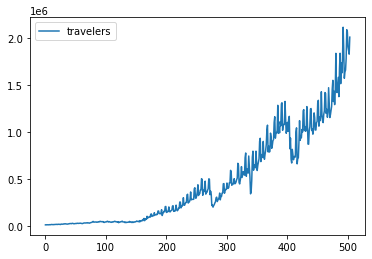

In [23]:
df_new.plot()

In [25]:
df_2015 = df_new.iloc[:-12]
df_2015

std_ym  travelers
0    197501       9544
1    197502       8549
2    197503      10332
3    197504      10504
4    197505      11380
..      ...        ...
487  201508    1835249
488  201509    1511657
489  201510    1735308
490  201511    1626063
491  201512    1781715

[492 rows x 2 columns]

In [35]:
# 2015년 12월까지의 데이터 추출
df_2015 = df_new.iloc[:-12]
df_2015.tail()

std_ym  travelers
487  201508    1835249
488  201509    1511657
489  201510    1735308
490  201511    1626063
491  201512    1781715

[Holt’s Winters Seasonal](https://www.statsmodels.org/stable/examples/notebooks/generated/exponential_smoothing.html)

In [36]:
from statsmodels.tsa.api import ExponentialSmoothing

# Holt-Winters의 additive 모델을 학습
model = ExponentialSmoothing(df_2015['travelers'], seasonal_periods=12, trend='add', seasonal='add').fit()
model.fittedvalues

C:\Users\djohn\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


0      9.789479e+03
1      8.878110e+03
2      1.068521e+04
3      1.085953e+04
4      1.173001e+04
           ...     
487    1.704063e+06
488    1.536112e+06
489    1.579057e+06
490    1.584727e+06
491    1.710551e+06
Length: 492, dtype: float64

In [39]:
# forecasted values
forecasted_values = model.forecast(12)
forecasted_values
ft = forecasted_values

In [40]:
# actual values
actual_values = df_new.iloc[-12:, 1]
actual_values
at = actual_values

In [41]:
N = 12

# 코드 입력
(100/N) * np.abs((at - ft) / at).sum().round(3)

4.483333333333334

**정답: 4.486**

## Q 3

```
X축에는 std_ym, 세로축에는 색상을 구분하여 Actual Value와 Forecasted Value에 대한 라인차트를 그리시오. 
Actual Value는 전체 기간에 대해, Forecasted Value는 201601~201612에 대해 그린다.
```

In [42]:
chart = pd.DataFrame({'std_ym':df_new.iloc[-12:, 0], 
                      'actual': actual_values, 
                      'forecast': forecasted_values,
                     })
chart

std_ym   actual      forecast
492  201601  2112337  2.036787e+06
493  201602  1876928  1.766142e+06
494  201603  1569162  1.707545e+06
495  201604  1636597  1.747163e+06
496  201605  1656728  1.825455e+06
497  201606  1778317  1.793727e+06
498  201607  2086068  2.068557e+06
499  201608  2064241  2.144440e+06
500  201609  1904524  1.850753e+06
501  201610  1865552  1.967553e+06
502  201611  1825701  1.841077e+06
503  201612  2007035  1.929454e+06

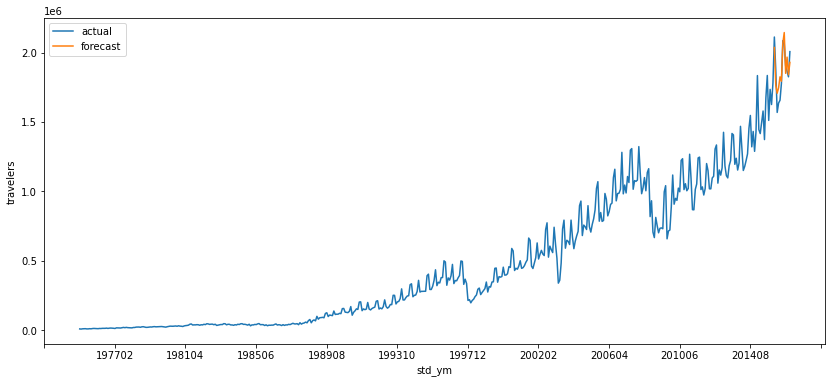

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 6)
# 코드 입력
sns.lineplot(data=df_new, x='std_ym', y='travelers', label='actual')
sns.lineplot(data=chart, x='std_ym', y='forecast', label='forecast')

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 50))
plt.show()